### Project individual IR patches of PV modules onto common ground plane

In [1]:
import os
import json
import csv
from collections import defaultdict
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from mapper.common import to_celsius, preprocess_radiometric_frame
from mapper.geometry import from_twist, to_twist, triangulate_map_points

from mapper.transforms import affine_matrix_from_points, decompose_matrix, \
    active_matrix_from_extrinsic_euler_xyz

In [2]:
def truncate_patch(patch, margin=0.1):
    """Truncates module edges by margin (percent of width) to remove module frame."""
    width = patch.shape[1]
    margin_px = int(margin*width)
    patch = patch[margin_px:-margin_px, margin_px:-margin_px]
    return patch


def get_max_mean_temp_patch(patch_files, patch_idxs_sun_reflections=[]):
    """Returns index of the patch in patch_files with largest mean temperature.
    Optionally ignores patches with sun reflections."""
    if len(patch_files) == 0:
        return None
    patch_idx = 0
    previous_mean_temp = -np.inf
    for idx, patch_file in enumerate(patch_files):
        if idx in patch_idxs_sun_reflections:  # ignore patches with sun reflections
            continue
        patch = cv2.imread(patch_file, cv2.IMREAD_ANYDEPTH)
        patch = truncate_patch(patch, margin=0.2)
        mean_temp = to_celsius(np.mean(patch))
        if mean_temp > previous_mean_temp:
            patch_idx = idx
            previous_mean_temp = mean_temp
    return patch_idx

In [3]:
def load_tracks(tracks_file):
    """Load Tracks CSV file."""
    tracks = defaultdict(list)
    with open(tracks_file, newline='', encoding="utf-8-sig") as csvfile:  # specifying the encoding skips optional BOM
        # automatically infer CSV file format
        dialect = csv.Sniffer().sniff(csvfile.readline(), delimiters=",;")
        csvfile.seek(0)
        csvreader = csv.reader(csvfile, dialect)
        for row in csvreader:
            frame_name = row[0]
            tracks[frame_name].append((row[1], row[2]))  # mask_name, track_id
    return tracks


def get_common_modules(tracks, first_frame_name, second_frame_name):
    """Retrieve mask names and track IDs of modules visible in two different frames.

    Args:
        tracks (`dict` of `list` of `tuple`): Tracks CSV file as created by tracking step of
            PV Module Extractor. Each row has format frame_name, mask_name, track_id, center_x, center_y

        first_frame_name (`str`): Name of the first frame in which to look for tracked modules.

        second_frame_name (`str`): Name of the second frame in which to look for the same
            tracked modules as in first frame.

    Returns:
        tracks_first_filtered: (`dict`) Track IDs (keys) and mask names (values)
            of all tracked modules which occur in both the first and second
            frame. Contains the mask names as they occur in the first frame.

        tracks_second_filtered: (`dict`) Track IDs (keys) and mask names (values)
            of all tracked modules which occur in both the first and second
            frame. Contains the mask names as they occur in the second frame.
    """
    tracks_first = {t[1]: t[0] for t in tracks[first_frame_name]}
    tracks_second = {t[1]: t[0] for t in tracks[second_frame_name]}
    common_track_ids = set(tracks_first.keys()) & set(tracks_second.keys())
    tracks_first_filtered = {k: v for k, v in tracks_first.items() if k in common_track_ids}
    tracks_second_filtered = {k: v for k, v in tracks_second.items() if k in common_track_ids}
    return tracks_first_filtered, tracks_second_filtered


def get_module_corners(root_dir, frame_name, mask_names):
    """Retrieve corners and center points for a given mask (module) and frame."""
    centers = []
    quadrilaterals = []
    for mask_name in mask_names:
        meta_file = os.path.join(root_dir, frame_name, "{}.pkl".format(mask_name))
        meta = pickle.load(open(meta_file, "rb"))
        centers.append(np.array(meta["center"]).reshape(1, 1, 2).astype(np.float64))
        quadrilaterals.append(np.array(meta["quadrilateral"]).reshape(-1, 2).astype(np.float64))
    return centers, quadrilaterals


def triangulate_modules(tracks_file, patches_meta_dir, pose_graph, camera_matrix):
    """Triangulate 3D map points of PV module corners and centers."""
    tracks = load_tracks(tracks_file)
    module_corners = defaultdict(list)
    module_centers = defaultdict(list)

    kf_poses = [pose_graph.nodes[n]["pose"] for n in pose_graph]
    kf_frame_names = [pose_graph.nodes[n]["frame_name"] for n in pose_graph]

    for first_pose, second_pose, first_frame_name, second_frame_name in zip(
            kf_poses, kf_poses[1:], kf_frame_names, kf_frame_names[1:]):

        tracks_first_filtered, tracks_second_filtered = get_common_modules(
            tracks, first_frame_name, second_frame_name)
        centers_first, corners_first = get_module_corners(
            patches_meta_dir, first_frame_name,
            tracks_first_filtered.values())
        centers_second, corners_second = get_module_corners(
            patches_meta_dir, second_frame_name,
            tracks_second_filtered.values())

        # triangulate 3D points
        R1, t1 = from_twist(first_pose)
        R2, t2 = from_twist(second_pose)

        for i, track_id in enumerate(tracks_first_filtered.keys()):
            module_corners[track_id].append(triangulate_map_points(
                corners_first[i], corners_second[i],
                R1, t1, R2, t2, camera_matrix))
            module_centers[track_id].append(triangulate_map_points(
                centers_first[i], centers_second[i],
                R1, t1, R2, t2, camera_matrix))

    # compute medians of observed center points
    module_corners = {
        track_id: np.median(np.stack(points), axis=0)
        for track_id, points in module_corners.items()}
    module_centers = {
        track_id: np.median(np.stack(points), axis=0)
        for track_id, points in module_centers.items()}

    # do not comput emedians and return all points instead
    #module_centers = {track_id: np.vstack(points) for track_id, points in module_centers.items()}
    #module_corners = {track_id: np.vstack(points) for track_id, points in module_corners.items()}
    return module_corners, module_centers

In [4]:
def get_transform_odometry2geo(pose_graph, gps):
    """Estimates a SIM(3) transform from camera poses (visual 
    odometry frame) to GPS frame based on all keyframe positions 
    and corresponding GPS positions.
    """
    nodes = list(sorted(pose_graph.nodes))
    poses = [from_twist(pose_graph.nodes[node_id]["pose"]) for node_id in nodes]
    positions = np.vstack([pose[1].reshape(3,) for pose in poses])

    # get GPS positions of each key frame
    keyframe_idxs = [int(pose_graph.nodes[node_id]["frame_name"][6:]) for node_id in nodes]
    gps_positions = np.zeros((len(keyframe_idxs), 3))
    gps_positions[:, 0:2] = np.array([gps[idx] for idx in keyframe_idxs])

    # compute scaling, rotation and translation between GPS trajectory and camera trajectory
    affine = affine_matrix_from_points(
        positions.T, gps_positions.T, shear=False, scale=True, usesvd=True)
    scale, _, angles, translation, _ = decompose_matrix(affine)
    scale = scale[0]
    rotation = active_matrix_from_extrinsic_euler_xyz(angles)
    print("similarity transform map -> GPS frame: {}, {}, {}".format(
        scale, translation, rotation))
    transform = (scale, translation, rotation)
    return transform


def points2gps(pts, transform):
    """Transforms 3D points to GPS frame."""
    scale, translation, rotation = transform
    return np.matmul(rotation, scale*pts.T).T + translation


def poses2gps(pose_graph, transform):
    """Transforms camera poses (translation only) to GPS frame."""
    scale, translation, rotation = transform
    nodes = list(sorted(pose_graph.nodes))
    poses = [from_twist(pose_graph.nodes[node_id]["pose"]) for node_id in nodes]
    positions = np.vstack([pose[1].reshape(3,) for pose in poses])
    rotations = [pose[0] for pose in poses]
    positions_mapped = np.matmul(rotation, scale*positions.T).T + translation
    for i, node_id in enumerate(nodes):
        pose_graph.nodes[node_id]["pose"] = to_twist(rotations[i], positions_mapped[i, :])

In [5]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))
gps_file = "../data_processing/splitted/gps/gps.json"
gps = json.load(open(gps_file, "r"))

In [6]:
module_corners = {}
module_centers = {}
try:
    patches_meta_dir = os.path.join("..", "data_processing", "patches", "meta")
    tracks_file = os.path.join("..", "data_processing", "tracking", "tracks_cluster_000000.csv")
    module_corners, module_centers = triangulate_modules(tracks_file, patches_meta_dir, pose_graph, camera_matrix)
except FileNotFoundError:
    pass

patches_root = os.path.join("..", "data_processing", "patches", "radiometric")

In [7]:
# obtain all patches for a given module based on its track ID

def load_tracks(tracks_file):
    """Load Tracks CSV file."""
    tracks_per_frame = defaultdict(list)
    tracks_per_id = defaultdict(list)
    with open(tracks_file, newline='', encoding="utf-8-sig") as csvfile:  # specifying the encoding skips optional BOM
        # automatically infer CSV file format
        dialect = csv.Sniffer().sniff(csvfile.readline(), delimiters=",;")
        csvfile.seek(0)
        csvreader = csv.reader(csvfile, dialect)
        for row in csvreader:
            frame_name = row[0]
            mask_name = row[1] 
            track_id = row[2]
            tracks_per_frame[frame_name].append((mask_name, track_id))
            tracks_per_id[track_id].append((frame_name, mask_name))
    return tracks_per_frame, tracks_per_id

tracks_per_frame, tracks_per_id = load_tracks(tracks_file)

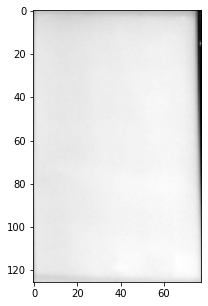

In [8]:
def get_patch(patches_root, track_id, tracks_per_id):
    # determine which patchhas the largest mean temperature
    patch_files = [os.path.join(patches_root, frame_name, "{}.tiff".format(mask_name))
        for frame_name, mask_name in tracks_per_id[track_id]]       
    patch_idx = get_max_mean_temp_patch(patch_files)
    # load patch
    patch = cv2.imread(patch_files[patch_idx], cv2.IMREAD_ANYDEPTH)
    patch = preprocess_radiometric_frame(patch, equalize_hist=False)  # we should only do that for the entire image but not per patch!
    return patch
    
    
patch = get_patch(patches_root, '30d6cec8-b6dc-45a4-920d-6825df592e41', tracks_per_id)

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.imshow(patch, cmap="gray")
plt.show()

In [9]:
# get extent of the plant, i.e. find minimum and maximum latitude and longitudes of all modules
def get_extent(module_corners):
    corners = np.vstack(list(module_corners.values()))
    min_latitude = np.min(corners[:, 1])
    max_latitude = np.max(corners[:, 1])
    min_longitude = np.min(corners[:, 0])
    max_longitude = np.max(corners[:, 0])
    return max_latitude, min_latitude, max_longitude, min_longitude

max_latitude, min_latitude, max_longitude, min_longitude = get_extent(module_corners)

In [10]:
def get_transform_geo2img(output_width, output_height, max_latitude, 
                          min_latitude, max_longitude, min_longitude):
    """Computes and affine transformation matrix for transforming 
    geo coordinates to image coordinates."""
    src_points = np.array([[min_longitude, min_latitude],
                           [max_longitude, min_latitude],
                           [max_longitude, max_latitude]])
    dst_points = np.array([[0, 0],
                           [output_width, 0],
                           [output_width, output_height]])
    transform = cv2.getAffineTransform(
            src_points.astype(np.float32), dst_points.astype(np.float32))
    return transform

In [11]:
def geo2img(pts_geo, transform):
    """Transforms geo coordinates to image coordinates."""
    pts_img = (transform @ cv2.convertPointsToHomogeneous(pts_geo.astype(np.float32).reshape(-1, 1, 2)).reshape(-1, 3).T).T
    return pts_img

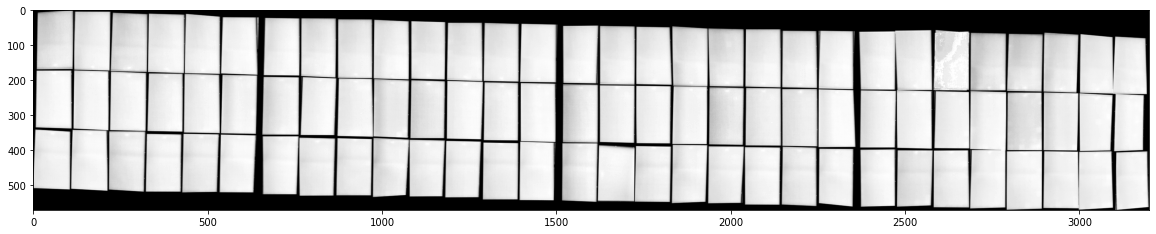

In [12]:
# determine size of output image
output_width = 3200  # px
scale = output_width / (max_longitude - min_longitude)
output_height = int(np.ceil(scale * (max_latitude - min_latitude)))

output_image = np.zeros((output_height, output_width), dtype=np.uint8)

transform = get_transform_geo2img(output_width, output_height, max_latitude, 
    min_latitude, max_longitude, min_longitude)

# project each module patch onto the z=0 plane
for i, (track_id, corners) in enumerate(module_corners.items()):
    
    #if i > 3:
    #    continue
    
    patch = get_patch(patches_root, track_id, tracks_per_id)
    h, w = patch.shape[:2]
    
    # find homography between patch and output image
    img_points = np.array([[0, 0],
                           [w, 0],
                           [w, h],
                           [0, h]])
    
    dst_points = corners[:, :-1]
    dst_points = geo2img(corners[:, :-1], transform)
    transmtx = cv2.getPerspectiveTransform(img_points.astype(np.float32), dst_points.astype(np.float32))
    
    # project patch into output image
    warped_patch = cv2.warpPerspective(patch, transmtx, (output_width, output_height), cv2.INTER_CUBIC, cv2.BORDER_REFLECT)
    
    mask = np.full((h, w), 255, dtype=np.uint8)
    warped_mask = cv2.warpPerspective(mask, transmtx, (output_width, output_height), cv2.INTER_NEAREST)
    
    output_image = cv2.bitwise_or(output_image, warped_patch)
    
    #fig = plt.figure()
    #fig.set_size_inches(20, 10)
    #plt.imshow(warped_patch, cmap="gray")
    #plt.show()
    
    #fig = plt.figure()
    #fig.set_size_inches(20, 10)
    #plt.imshow(warped_mask, cmap="gray")
    #plt.show()
    #break
    
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(output_image, cmap="gray")
plt.show()

In [13]:
cv2.imwrite("output.jpg", output_image)

True